# Удаление неадекватных примеров

## Импорт библиотек

In [134]:
import pandas as pd
import numpy as np
import torch
import csv
import matplotlib.pyplot as plt

## Создание датасетов и разделение данных

In [2]:
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
class PermAppartmentDataset(Dataset):
    def __init__(self, filename):
        super().__init__()
        data = pd.read_csv(filename, sep=';')
        self.y = torch.from_numpy(data.price.values).to(dtype=torch.float32)
        self.x = torch.from_numpy(data.drop('price', axis=1).values).to(dtype=torch.float32)
        self.n = len(self.y)
        del data
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [4]:
dataset = PermAppartmentDataset('../final_data.csv')

# Загрузчики данных

In [5]:
dataset_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Составление модели

In [38]:
def train_loop(n_epoch, loss, optimizer, train_dl, val_dl, train_size, valid_size, every_n_epoch_print=1000):
    global model
    train_losses = []
    valid_losses = []
    for epoch in range(n_epoch):
        #   Считаем ошибку на тестовой выборке
        train_loss = 0
        val_loss = 0
        model.eval()
        with torch.no_grad():
            #   Считаем ошибку на обучающей выборке
            for i, (X, y) in enumerate(train_dl):
                y_pred = model(X)
                l = loss(y_pred, y.reshape(-1, 1))
                train_loss += l.item() * len(y)
            #   Считаем ошибку на тестовой выборке
            for i, (X, y) in enumerate(val_dl):
                y_pred = model(X)
                l = loss(y_pred, y.reshape(-1, 1))
                val_loss += l.item() * len(y)
        model.train()
        train_losses.append(np.sqrt(train_loss / train_size))
        valid_losses.append(np.sqrt(val_loss / valid_size))
        if epoch%every_n_epoch_print == 0:
            print(epoch, "/", n_epoch, " : ", 
                  " train loss = ", np.sqrt(train_loss / train_size),
                  " val loss = ", np.sqrt(val_loss / valid_size))

        # Бежим по пакетам (batches)
        for i, (X, y) in enumerate(train_dl):
            # Предсказание
            y_pred = model(X)
            l = loss(y_pred, y.reshape(-1, 1))
            # Расчёт градиентов
            l.backward()
            # Оптимизация
            optimizer.step()
            # Зануляем градиент
            optimizer.zero_grad()
    return train_losses, valid_losses

In [20]:
def evaluate_on_test(loss, test_dl, test_size):
    global model
    predicts = []
    reals = []
    test_loss = 0
    model.eval()
    with torch.no_grad():
        #   Считаем ошибку на тестовой выборке
        for i, (X, y) in enumerate(test_dl):
            y_pred = model(X)
            for real, predict in zip(y.reshape(-1), y_pred.reshape(-1)):
                real_value = real.item()
                predict_value = predict.item()
                predicts.append(predict_value)
                reals.append(real_value)
            l = loss(y_pred, y.reshape(-1, 1))
            test_loss += l.item() * len(y)
    model.train()
    
    print("test loss = ", np.sqrt(test_loss / test_size))
    return np.array(reals), np.array(predicts)

## Линейная регрессия без байеса и без регуляризации

In [7]:
import torch.nn as nn

In [13]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(37, 1, bias=False)

    def forward(self, x):
        res = self.fc1(x)
        return res

In [54]:
model = LinearRegression()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00000001)

In [22]:
reals, predicts = evaluate_on_test(
    loss = loss, 
    test_dl = dataset_loader, 
    test_size = len(dataset), 
)

test loss =  4994663.430334999


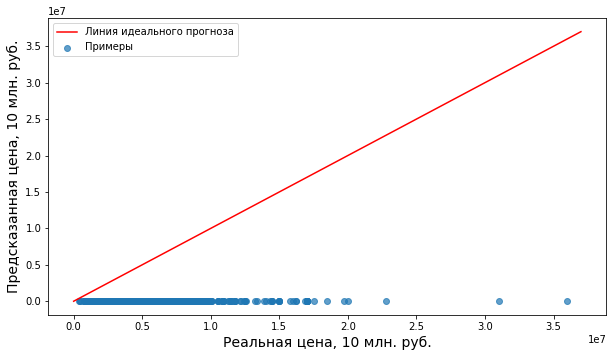

In [29]:
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
plt.plot([0, 37_000_000], [0, 37_000_000], c='r', label='Линия идеального прогноза')
plt.scatter(reals, predicts, alpha=0.7, label='Примеры')
plt.xlabel("Реальная цена, 10 млн. руб.", size=14)
plt.ylabel("Предсказанная цена, 10 млн. руб.", size=14)
plt.legend()

In [55]:
losses, _ = train_loop(
    n_epoch = 2001,
    every_n_epoch_print=100,
    loss = loss, 
    optimizer = optimizer,
    train_dl = dataset_loader, 
    val_dl = [], 
    train_size = len(dataset), 
    valid_size = 1
)

0 / 2001  :   train loss =  4994392.230146478  val loss =  0.0
100 / 2001  :   train loss =  2428345.955894371  val loss =  0.0
200 / 2001  :   train loss =  2291958.4766698075  val loss =  0.0
300 / 2001  :   train loss =  2282314.8252267153  val loss =  0.0
400 / 2001  :   train loss =  2230904.796090514  val loss =  0.0
500 / 2001  :   train loss =  1952974.9758658207  val loss =  0.0
600 / 2001  :   train loss =  1902673.1100494545  val loss =  0.0
700 / 2001  :   train loss =  1946629.5987084971  val loss =  0.0
800 / 2001  :   train loss =  1738710.1058543175  val loss =  0.0
900 / 2001  :   train loss =  1827886.0615756467  val loss =  0.0
1000 / 2001  :   train loss =  1611777.8652843419  val loss =  0.0
1100 / 2001  :   train loss =  1585717.7845577893  val loss =  0.0
1200 / 2001  :   train loss =  1526123.4842777867  val loss =  0.0
1300 / 2001  :   train loss =  1496279.3286313338  val loss =  0.0
1400 / 2001  :   train loss =  1462094.2574614473  val loss =  0.0
1500 / 200

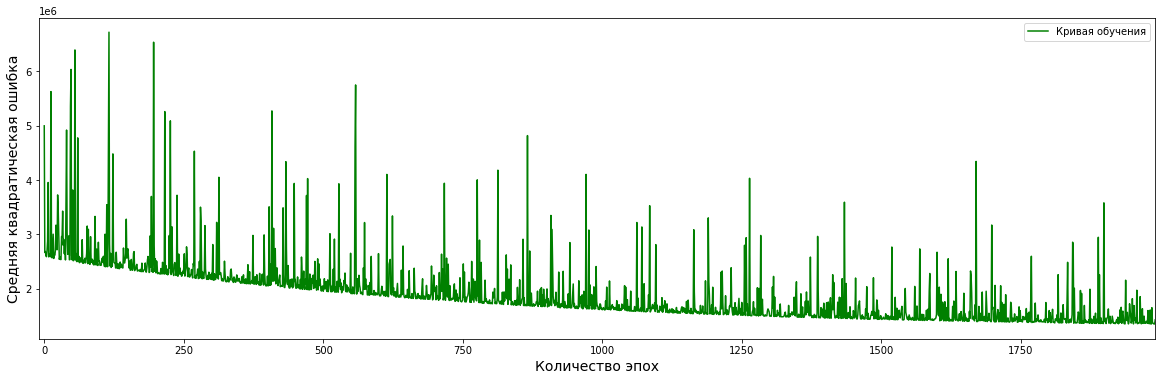

In [65]:
plt.figure(figsize=(20, 13))
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(losses)), losses, c='g', label='Кривая обучения')
plt.xlabel("Количество эпох", size=14)
plt.ylabel("Средняя квадратическая ошибка", size=14)
plt.xlim(-10, 1990)
plt.legend()

In [67]:
reals, predicts = evaluate_on_test(
    loss = loss, 
    test_dl = dataset_loader, 
    test_size = len(dataset), 
)

test loss =  1402688.6089497365


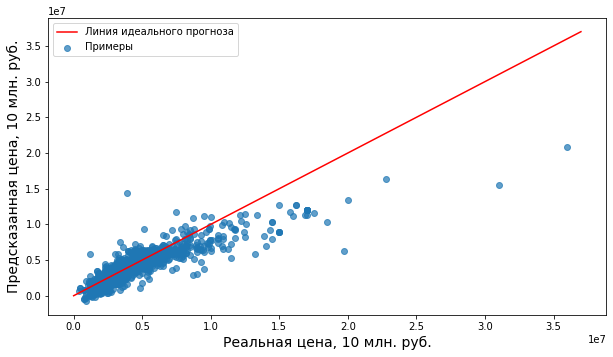

In [68]:
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
plt.plot([0, 37_000_000], [0, 37_000_000], c='r', label='Линия идеального прогноза')
plt.scatter(reals, predicts, alpha=0.7, label='Примеры')
plt.xlabel("Реальная цена, 10 млн. руб.", size=14)
plt.ylabel("Предсказанная цена, 10 млн. руб.", size=14)
plt.legend()

In [74]:
len(dataset)

1767

In [225]:
new_dataset = []

for (X, y) in dataset:
    result = model(X)
    if abs(result - y) > 1_000_000:
        pass
    else:
        new_dataset.append((X,y))

In [226]:
len(new_dataset)

1311

In [227]:
new_dataset_loader = DataLoader(new_dataset, batch_size=32, shuffle=True)

In [228]:
reals, predicts = evaluate_on_test(
    loss = loss, 
    test_dl = new_dataset_loader, 
    test_size = len(new_dataset), 
)

test loss =  537512.3175801773


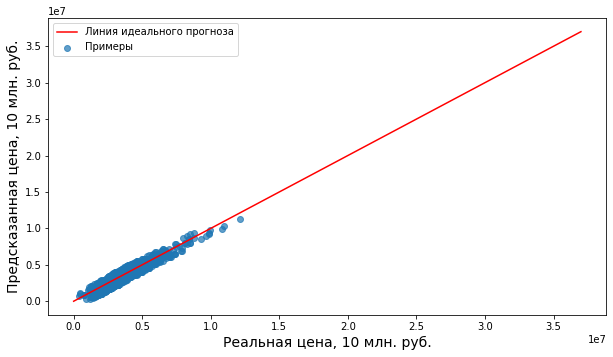

In [229]:
plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
plt.plot([0, 37_000_000], [0, 37_000_000], c='r', label='Линия идеального прогноза')
plt.scatter(reals, predicts, alpha=0.7, label='Примеры')
plt.xlabel("Реальная цена, 10 млн. руб.", size=14)
plt.ylabel("Предсказанная цена, 10 млн. руб.", size=14)
plt.legend()

## Разделение данных

In [235]:
test_size = int(0.10 * len(new_dataset))
valid_size = int(0.10 * len(new_dataset))
train_size = len(new_dataset) - test_size - valid_size

In [237]:
test_set, valid_set, train_set = random_split(new_dataset, [test_size, valid_size, train_size])

In [238]:
print("Размер тестового множества: " + str(len(test_set)))

Размер тестового множества: 131


In [239]:
print("Размер валидационного множества: " + str(len(valid_set)))

Размер валидационного множества: 131


In [240]:
print("Размер тренировочного множества: " + str(len(train_set)))

Размер тренировочного множества: 1049


## Сохранение данных

In [241]:
def save_dataset_to_csv(filename, dataset, header):
    with open(filename, 'w', newline='', encoding="UTF-8") as file:
        writer = csv.writer(file, delimiter = ";")
        writer.writerow(header)
        for (X, y) in dataset:
            features = list(np.array(X))
            target = y.item()
            features.append(target)            
            writer.writerow(features)

In [242]:
header = [
        'number of rooms', 'area of apartment', 'number of floors',
       'apartment floor', 'year of construction', 'elevator',
       'concierge', 'garbage chute', 'repair_дизайнерский', 'repair_евро',
       'repair_косметический', 'repair_требует ремонта', 'bathroom_несколько',
       'bathroom_раздельный', 'bathroom_совмещенный', 'terrace_балкон',
       'terrace_лоджия', 'terrace_нет', 'type of house_блочный',
       'type of house_деревянный', 'type of house_кирпичный',
       'type of house_монолитный', 'type of house_панельный',
       'district_Дзержинский', 'district_Индустриальный', 'district_Кировский',
       'district_Ленинский', 'district_Мотовилихинский',
       'district_Орджоникидзевский', 'district_Свердловский', 'lat', 'lon',
       'edu', 'health', 'culture', 'eat', 'distance', 'price'
]

In [243]:
save_dataset_to_csv('../final_train.csv', train_set, header)
save_dataset_to_csv('../final_valid.csv', valid_set, header)
save_dataset_to_csv('../final_test.csv', test_set, header)